In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

from data_load import *
from model_fit_functions import *

from sklearn.utils import shuffle

import pandas as pd
import numpy as np

import os
import pickle


from sklearn.random_projection import GaussianRandomProjection

import random 
from sklearn.metrics.pairwise import euclidean_distances


In [2]:
directory_list = ['Complete_Spectral_Data\Training_Data', 'Complete_Spectral_Data\Test_Data']
data_all = get_data_from_directory_list(directory_list)

spectral_data = data_all["spectral_properties"]
physical_data = data_all["physical_properties"]

print(spectral_data.shape)
print(physical_data.shape)

spectral_data, physical_data = shuffle(spectral_data, physical_data, random_state = 5684)


train_size = 1346
val_size   = 430

x_train = spectral_data[: train_size, :]
x_val   = spectral_data[train_size : train_size + val_size, :]
x_test  = spectral_data[train_size + val_size:]

y_train = physical_data[: train_size, :]
y_val   = physical_data[train_size : train_size + val_size, :]
y_test  = physical_data[train_size + val_size:, :]

x_train_df = pd.DataFrame(x_train)

y_var_cols = ['virial_rad', 'stellar_rad', 'impact', 'mass', 'disc']


y_train_df = pd.DataFrame(y_train, columns = y_var_cols) #.describe()
y_train_df.describe()

# Natural log of radii and mass
y_train_ln = np.concatenate( (np.log(y_train[:, 0:2]), 
                              y_train[:, 2].reshape(-1, 1), 
                              np.log(y_train[:, 3]).reshape(-1, 1), 
                              y_train[:, 4].reshape(-1, 1)), axis = 1)

y_train_ln_df = pd.DataFrame(y_train_ln, columns = y_var_cols) #.describe()

y_val_ln = np.concatenate( (np.log(y_val[:, 0:2]), 
                              y_val[:, 2].reshape(-1, 1), 
                              np.log(y_val[:, 3]).reshape(-1, 1), 
                              y_val[:, 4].reshape(-1, 1)), axis = 1)

y_val_ln_df = pd.DataFrame(y_val_ln, columns = y_var_cols)

y_test_ln = np.concatenate( (np.log(y_test[:, 0:2]), 
                              y_test[:, 2].reshape(-1, 1), 
                              np.log(y_test[:, 3]).reshape(-1, 1), 
                              y_test[:, 4].reshape(-1, 1)), axis = 1)

y_test_ln_df = pd.DataFrame(y_test_ln, columns = y_var_cols)

Directory: Complete_Spectral_Data\Training_Data Physical properties shape: (1346, 5) Spectral prop shape: (1346, 110001)
Directory: Complete_Spectral_Data\Test_Data Physical properties shape: (810, 5) Spectral prop shape: (810, 110001)
(2156, 110001)
(2156, 5)


In [4]:
train_df_pooled = pooling_for_x(x_train, 10, np.mean)
val_df_pooled = pooling_for_x(x_val, 10, np.mean)

scaler = StandardScaler()

scaler.fit(train_df_pooled)

train_df_pooled = pd.DataFrame(scaler.transform(train_df_pooled))
val_df_pooled = pd.DataFrame(scaler.transform(val_df_pooled))

(1346, 110001)
(1346, 9)
(1346, 110010)
(430, 110001)
(430, 9)
(430, 110010)


In [13]:
random.seed(2627)

x_train = train_df_pooled.copy().to_numpy()
x_val = val_df_pooled.copy().to_numpy()


train_dict = dict()
val_dict = dict()

n_samples_train = x_train.shape[0]
n_samples_val = x_val.shape[0]
p_dim = x_train.shape[1]

for n_comp in np.arange(1, 5000, 200):
    
    print(n_comp)
    
    # initialise object
    random_proj = GaussianRandomProjection(n_components = n_comp)
    x_train_transformed = random_proj.fit_transform(x_train)
    x_val_transformed = random_proj.fit_transform(x_val)
    
    # select a random subsample of size 100
    train_sample = random.sample(np.arange(0, x_train.shape[0], 1).tolist(), 100)
    val_sample = random.sample(np.arange(0, x_val.shape[0], 1).tolist(), 100)
    
    x_to_compare_train = x_train_transformed[train_sample, :]
    x_to_compare_val = x_val_transformed[val_sample, :]
    
    # train set 
    distances_original_train = euclidean_distances(x_train[train_sample, :], squared=True).ravel() #[nonzero]
    nonzero_train = distances_original_train  != 0
    distances_original_train  = distances_original_train[nonzero_train]

    # train set: calculate euclidean distances, drop zero distances (point with itself)
    distances_projected_train = euclidean_distances(x_to_compare_train, squared=True ).ravel()[nonzero_train] 
    
    # val set
    distances_original_val = euclidean_distances(x_val[val_sample, :], squared=True).ravel() #[nonzero]
    nonzero_val = distances_original_val  != 0
    distances_original_val  = distances_original_val[nonzero_val]

    # val set: # calculate euclidean distances, drop zero distances (point with itself)
    distances_projected_val = euclidean_distances(x_to_compare_val, squared=True ).ravel()[nonzero_val]    
    
    # ratios of pointwise distances in the projected and original space
    ratios_train = distances_projected_train / distances_original_train
    
    # Save results to an object
    train_dict[n_comp] = dict()
    train_dict[n_comp]["ratios"] = ratios_train
    train_dict[n_comp]["ratios_mean"] = ratios_train.mean()
    train_dict[n_comp]["ratios_std"] = ratios_train.std()
    
    # save val
    ratios_val = distances_projected_val / distances_original_val
    
    val_dict[n_comp] = dict()
    val_dict[n_comp]["ratios"] = ratios_val
    val_dict[n_comp]["ratios_mean"] = ratios_val.mean()
    val_dict[n_comp]["ratios_std"] = ratios_val.std()    
        
    # map back to the original space (note that this is approximate as the transformation matrix is orthogonal only
    # in expectation)
    x_original_space_train = x_train_transformed @ random_proj.components_
    x_original_space_val = x_val_transformed @ random_proj.components_
    
    loss_train = ((x_original_space_train.ravel() - x_train.ravel()) ** 2).sum().sum()/(n_samples_train*p_dim)
    loss_val = ((x_original_space_val.ravel() - x_val.ravel()) ** 2).sum().sum()/(n_samples_val*p_dim)
    
    train_dict[n_comp]["loss_train"] = loss_train
    val_dict[n_comp]["loss_val"] = loss_val

1
here1
here2
here3
201
here1
here2
here3
401
here1
here2
here3
601
here1
here2
here3
801
here1
here2
here3
1001
here1
here2
here3
1201
here1
here2
here3
1401
here1
here2
here3
1601
here1
here2
here3
1801
here1
here2
here3
2001
here1
here2
here3
2201
here1
here2
here3
2401
here1
here2
here3
2601
here1
here2
here3
2801
here1
here2
here3
3001
here1
here2
here3
3201
here1
here2
here3
3401
here1
here2
here3
3601
here1
here2
here3
3801
here1
here2
here3
4001
here1
here2
here3
4201
here1
here2
here3
4401
here1
here2
here3
4601
here1
here2
here3
4801
here1
here2
here3


In [15]:
# collect the train and validation set results into a single object, whih is then saved
random_proj = dict()
random_proj["train"] = train_dict
random_proj["val"] = val_dict

# Save the object (commented out to prevent overwriting)
# dump_object("randomproj_sequence_long", random_proj)

()

In [337]:
# Plot losses (in terms of the reconstruction error)
n_comp_list = list(val_dict.keys())
losses_train_list = [train_dict[i]["loss_train"] for i in val_dict.keys()]
losses_val_list = [val_dict[i]["loss_val"] for i in val_dict.keys()]

(0.0, 500.0)

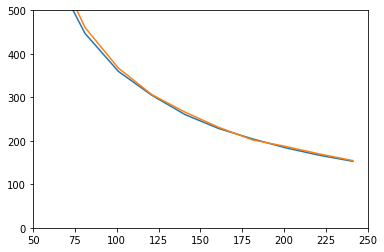

In [338]:
fig, ax = plt.subplots()
ax.plot( np.array(n_comp_list), np.array(losses_train_list) )
ax.plot( np.array(n_comp_list), np.array(losses_val_list) )
ax.set_xlim([50, 250])
ax.set_ylim([0, 500])

In [342]:
# Plot the ratio of original vs transformed distances

# Note tha tthis is calculated on a 100 randomly selected datapoints. Datapoints as well as the transformation matrix are
# drawn separately for each number of components.

n_comp_list = list(val_dict.keys())
ratios_mean_list = [train_dict[i]["ratios_mean"] for i in val_dict.keys()]
ratios_std_list = [train_dict[i]["ratios_std"] for i in val_dict.keys()]

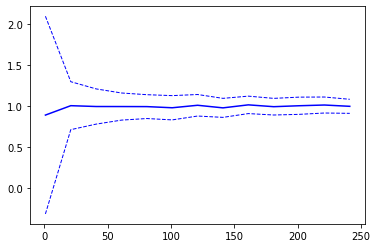

In [355]:
fig, ax = plt.subplots()
ax.plot( np.array(n_comp_list), np.array(ratios_mean_list), color = "blue" )
ax.plot( np.array(n_comp_list), np.array(ratios_mean_list) + np.array(ratios_std_list), color = "blue", 
        linestyle = "--", linewidth = '1' )
ax.plot( np.array(n_comp_list), np.array(ratios_mean_list) - np.array(ratios_std_list), color = "blue",
        linestyle = "--", linewidth = '1' )
ax.title


Text(0, 0.5, 'Distribution of samples pairs')

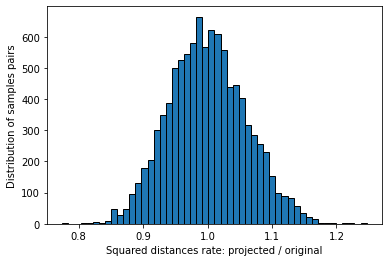

In [271]:
# Histogram of original vs projected distances 

rates = distances_projected / distances_original

plt.figure()
plt.hist(rates, bins=50, edgecolor='k')
plt.xlabel("Squared distances rate: projected / original")
plt.ylabel("Distribution of samples pairs")